# FakeNewsNetClassifier

This notebook builds and evaluates machine learning models for detecting fake news using the FakeNewsNet dataset, that contians two subsets, GossipCop and PolitiFact.
I will be using three different classifiers: Logistic Regression, Support Vector Machine (SVM), and Naive Bayes.
I will also balance the dataset using SMOTE and perform hyperparameter tuning to improve models' performance

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import joblib

## Load Preprocessed Data from Google Drive

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the preprocessed datasets from Google Drive
gossipcop_combined = pd.read_csv('/content/drive/My Drive/gossipcop_preprocessed.csv')
politifact_combined = pd.read_csv('/content/drive/My Drive/politifact_preprocessed.csv')

# Quick check of the data loaded
print(gossipcop_combined.head())
print(politifact_combined.head())

Mounted at /content/drive
                                               title  label
0  lea michel hairstylist mix textur spray coconu...      1
1  thoma markl princ harri polit miss daughter me...      0
2  2019 sag award nomin see full list nomine varieti      1
3  see meghan markl royal coat arm symbol hide wi...      1
4    kyli jenner visit shaman life kyli season final      1
                                               title  label
0         world popular candi remov shelv octob 2017      0
1                             brows congression bill      1
2                          suprem court vacanc video      1
3                                    u import export      1
4  die 78 year old cia agent admit kill marilyn m...      0


## Check loaded data

In [3]:
# Check for NaN values in datasets
print("NaN values in GossipCop dataset:\n", gossipcop_combined.isnull().sum())
print("NaN values in PolitiFact dataset:\n", politifact_combined.isnull().sum())

# Ensure there are no NaN values
gossipcop_combined.dropna(inplace=True)
politifact_combined.dropna(inplace=True)

# Re-check for NaN values in datasets
print("NaN values in GossipCop dataset after dropna:\n", gossipcop_combined.isnull().sum())
print("NaN values in PolitiFact dataset after dropna:\n", politifact_combined.isnull().sum())

NaN values in GossipCop dataset:
 title    1
label    0
dtype: int64
NaN values in PolitiFact dataset:
 title    2
label    0
dtype: int64
NaN values in GossipCop dataset after dropna:
 title    0
label    0
dtype: int64
NaN values in PolitiFact dataset after dropna:
 title    0
label    0
dtype: int64


## Split Data into Training and Testing Sets

I am splitting the dataset the same way as Shu et al. [7]: "We use 80% of data for training and 20% for testing."

In [4]:
# Define features (X) and labels (y)
X_gossipcop = gossipcop_combined['title']
y_gossipcop = gossipcop_combined['label']

X_politifact = politifact_combined['title']
y_politifact = politifact_combined['label']

# Split the data into training and testing sets (80% train, 20% test)
X_train_gossipcop, X_test_gossipcop, y_train_gossipcop, y_test_gossipcop = train_test_split(X_gossipcop, y_gossipcop, test_size=0.2, random_state=42)
X_train_politifact, X_test_politifact, y_train_politifact, y_test_politifact = train_test_split(X_politifact, y_politifact, test_size=0.2, random_state=42)

## Vectorize the Text Data Using TF-IDF

 Shen et al [6] applied TF-IDF technique for feature extraction, so I will use this too. TF-IDF should be applied after splitting the data to avoid data leakage. The vectorizer is only fitted on the training data and then applied to the test data.

In [5]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the training data, transform the test data
X_train_gossipcop_tfidf = vectorizer.fit_transform(X_train_gossipcop)
X_test_gossipcop_tfidf = vectorizer.transform(X_test_gossipcop)

X_train_politifact_tfidf = vectorizer.fit_transform(X_train_politifact)
X_test_politifact_tfidf = vectorizer.transform(X_test_politifact)

## Balance classes using SMOTE

SMOTE is a popular technique, that can be applied to balance an imbalanced dataset as descibed by Chawla et al.[14]. It generates synthetic examples for the minority class. The method combines minority class examples to create synthetic examples and balances the class distribution. It improves classifier performance on imbalanced datasets. I apply this technique to balance the class imbalance present in the original datasets.

In [6]:
# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
X_train_gossipcop_resampled, y_train_gossipcop_resampled = smote.fit_resample(X_train_gossipcop_tfidf, y_train_gossipcop)
X_train_politifact_resampled, y_train_politifact_resampled = smote.fit_resample(X_train_politifact_tfidf, y_train_politifact)

# Check class distribution after SMOTE
print("Class distribution in resampled GossipCop training set:")
print(pd.Series(y_train_gossipcop_resampled).value_counts())

print("Class distribution in resampled PolitiFact training set:")
print(pd.Series(y_train_politifact_resampled).value_counts())

Class distribution in resampled GossipCop training set:
label
0    13428
1    13428
Name: count, dtype: int64
Class distribution in resampled PolitiFact training set:
label
0    492
1    492
Name: count, dtype: int64


## Train and Evaluate Classifiers

In [7]:
# Train and evaluate the model, returning the model and predictions
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(cm)
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    # Plot ROC Curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:  # Use decision_function if predict_proba is not available
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    # Return the trained model and predictions
    return model, y_pred

### Model Training and Evaluation

Logistic Regression (GossipCop):
Accuracy: 0.7850
Precision: 0.8999
Recall: 0.8090
F1-score: 0.8520
ROC AUC: 0.7579
Confusion Matrix:
[[ 735  305]
 [ 647 2741]]


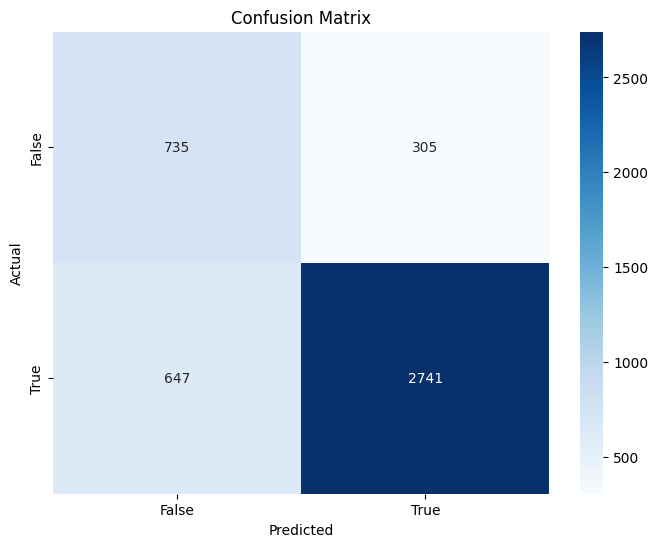

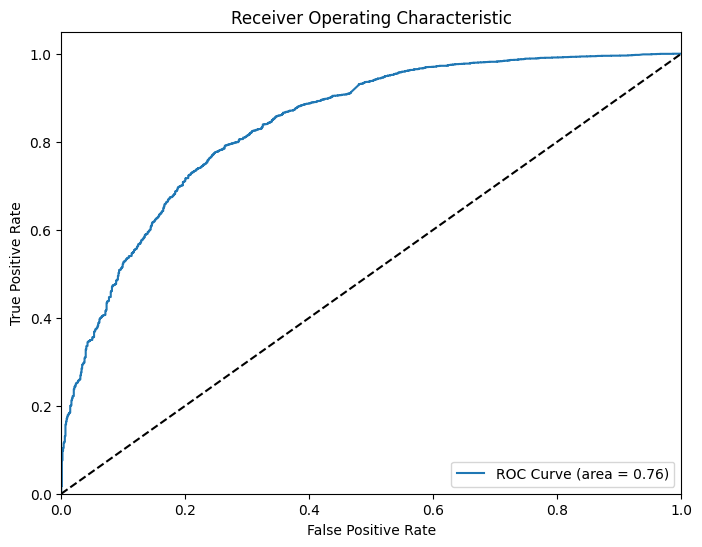


Logistic Regression (PolitiFact):
Accuracy: 0.7962
Precision: 0.8919
Recall: 0.7615
F1-score: 0.8216
ROC AUC: 0.8067
Confusion Matrix:
[[69 12]
 [31 99]]


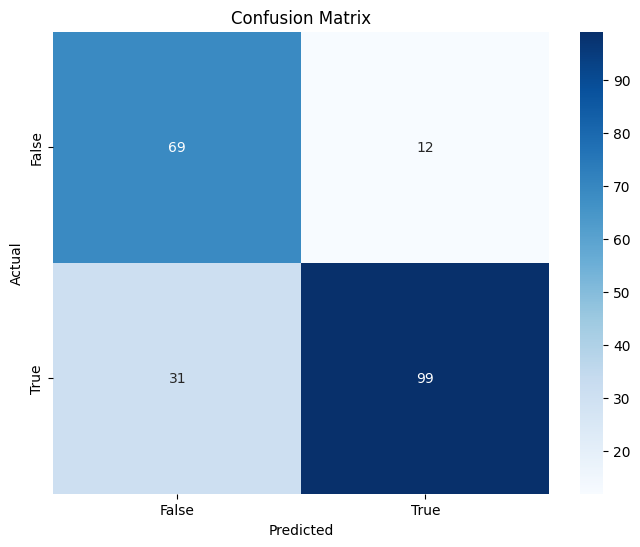

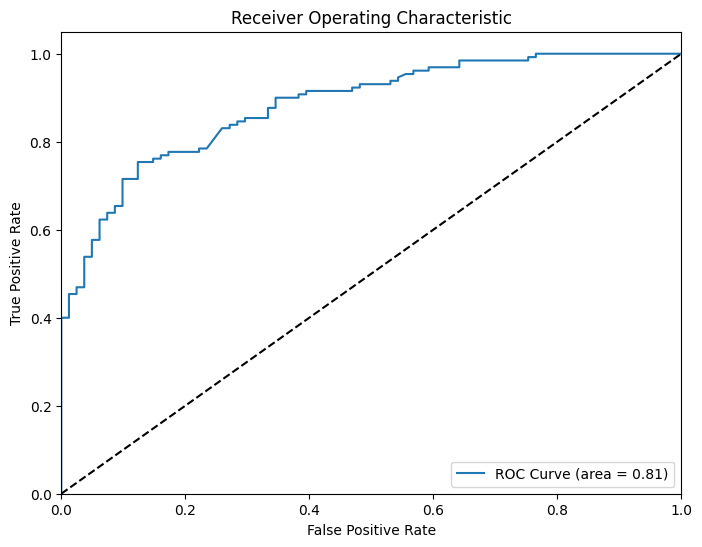


Support Vector Machine (GossipCop):
Accuracy: 0.7764
Precision: 0.9002
Recall: 0.7960
F1-score: 0.8449
ROC AUC: 0.7543
Confusion Matrix:
[[ 741  299]
 [ 691 2697]]


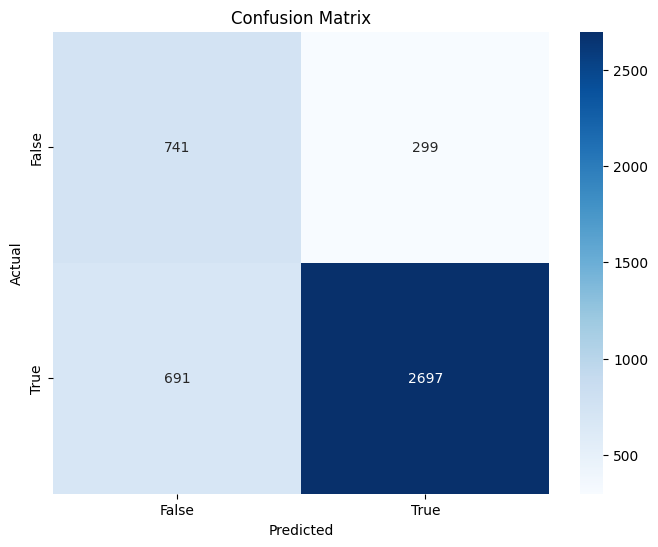

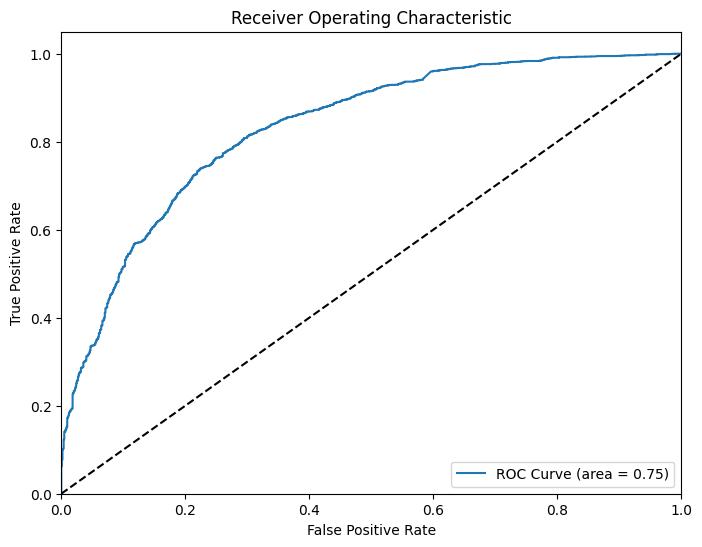


Support Vector Machine (PolitiFact):
Accuracy: 0.7820
Precision: 0.8750
Recall: 0.7538
F1-score: 0.8099
ROC AUC: 0.7905
Confusion Matrix:
[[67 14]
 [32 98]]


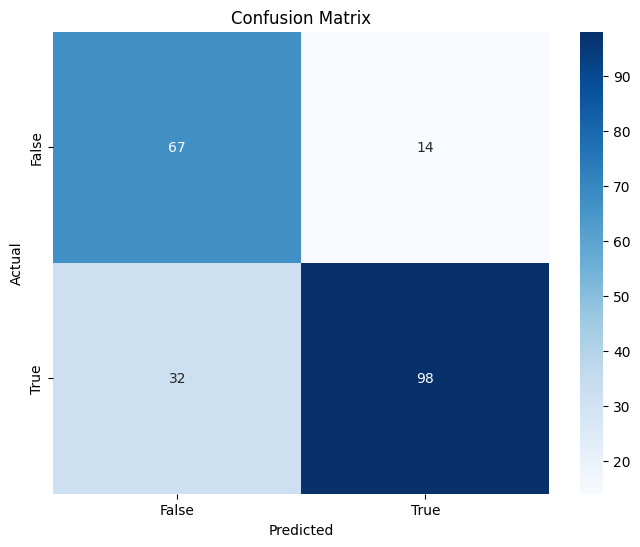

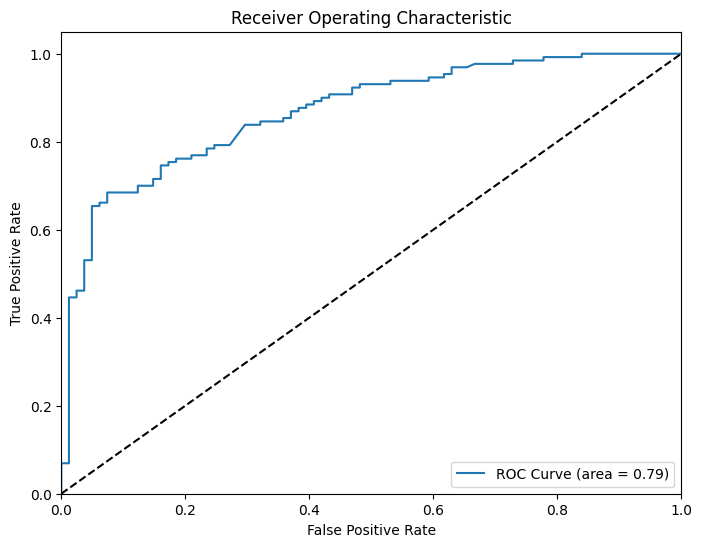


Naive Bayes (GossipCop):
Accuracy: 0.7809
Precision: 0.9009
Recall: 0.8019
F1-score: 0.8485
ROC AUC: 0.7572
Confusion Matrix:
[[ 741  299]
 [ 671 2717]]


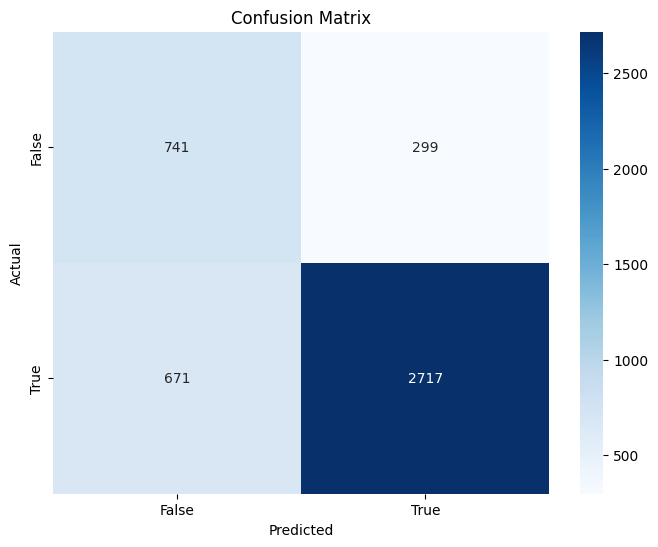

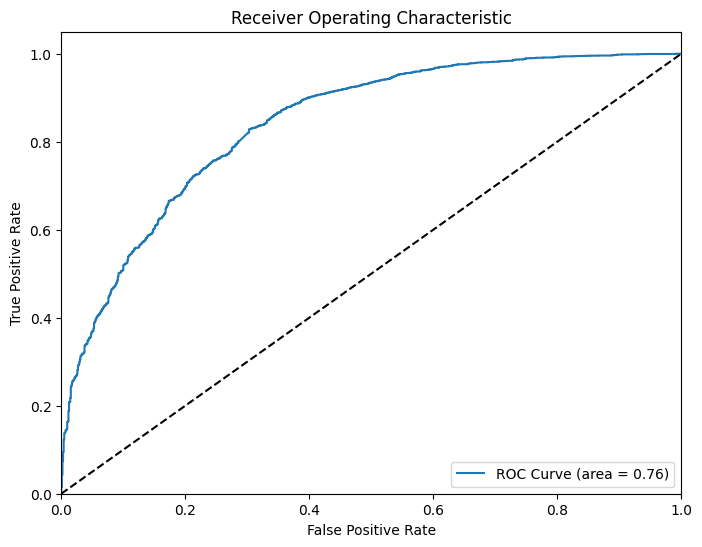


Naive Bayes (PolitiFact):
Accuracy: 0.7867
Precision: 0.8761
Recall: 0.7615
F1-score: 0.8148
ROC AUC: 0.7943
Confusion Matrix:
[[67 14]
 [31 99]]


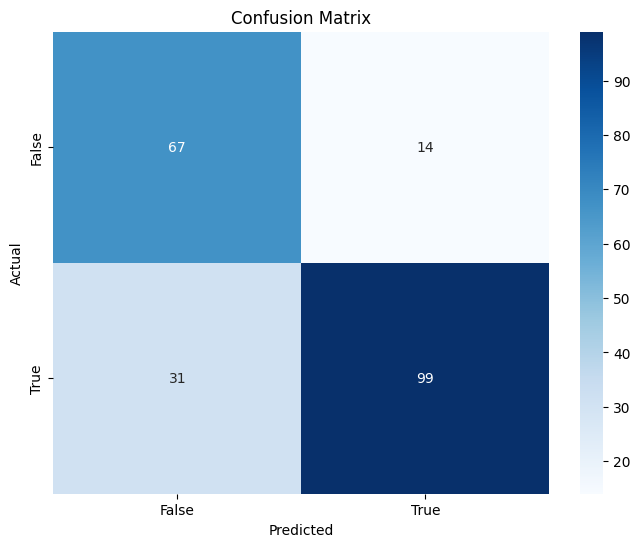

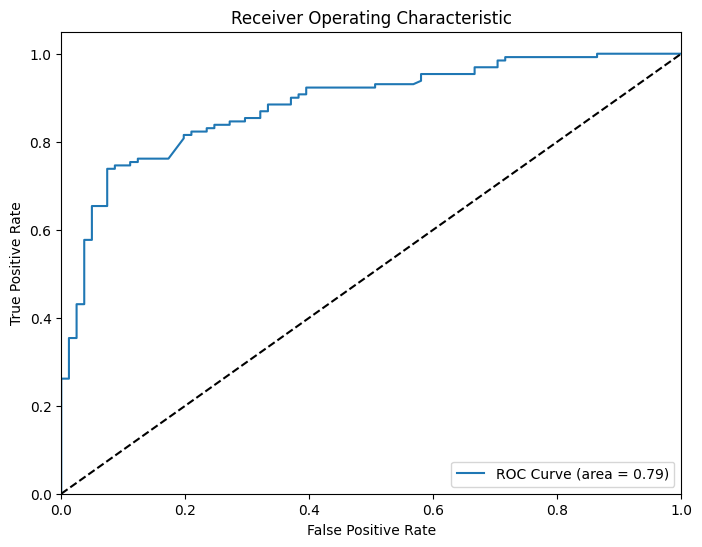

(MultinomialNB(),
 array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))

In [8]:
# Logistic Regression
print("Logistic Regression (GossipCop):")
logistic_model_gossipcop = LogisticRegression(max_iter=1000)
train_and_evaluate(logistic_model_gossipcop, X_train_gossipcop_resampled, X_test_gossipcop_tfidf, y_train_gossipcop_resampled, y_test_gossipcop)

print("\nLogistic Regression (PolitiFact):")
logistic_model_politifact = LogisticRegression(max_iter=1000)
train_and_evaluate(logistic_model_politifact, X_train_politifact_resampled, X_test_politifact_tfidf, y_train_politifact_resampled, y_test_politifact)

# Support Vector Machine (SVM)
print("\nSupport Vector Machine (GossipCop):")
svm_model_gossipcop = SVC(kernel='linear')
train_and_evaluate(svm_model_gossipcop, X_train_gossipcop_resampled, X_test_gossipcop_tfidf, y_train_gossipcop_resampled, y_test_gossipcop)

print("\nSupport Vector Machine (PolitiFact):")
svm_model_politifact = SVC(kernel='linear')
train_and_evaluate(svm_model_politifact, X_train_politifact_resampled, X_test_politifact_tfidf, y_train_politifact_resampled, y_test_politifact)

# Naive Bayes
print("\nNaive Bayes (GossipCop):")
nb_model_gossipcop = MultinomialNB()
train_and_evaluate(nb_model_gossipcop, X_train_gossipcop_resampled, X_test_gossipcop_tfidf, y_train_gossipcop_resampled, y_test_gossipcop)

print("\nNaive Bayes (PolitiFact):")
nb_model_politifact = MultinomialNB()
train_and_evaluate(nb_model_politifact, X_train_politifact_resampled, X_test_politifact_tfidf, y_train_politifact_resampled, y_test_politifact)

### Comparison of my results with baseline Shu et al. [7]

GossipCop Dataset

Support Vector Machine (SVM)

    My Results:
        Accuracy: 0.7764
        Precision: 0.9002
        Recall: 0.7960
        F1-score: 0.8449
    Baseline Results:
        Accuracy: 0.497
        Precision: 0.511
        Recall: 0.713
        F1-score: 0.595

Logistic Regression

    My Results:
        Accuracy: 0.7850
        Precision: 0.8999
        Recall: 0.8090
        F1-score: 0.8520
    Baseline Results:
        Accuracy: 0.648
        Precision: 0.675
        Recall: 0.619
        F1-score: 0.646

Naive Bayes

    My Results:
        Accuracy: 0.7809
        Precision: 0.9009
        Recall: 0.8019
        F1-score: 0.8485
    Baseline Results:
        Accuracy: 0.624
        Precision: 0.631
        Recall: 0.669
        F1-score: 0.649

PolitiFact Dataset

Support Vector Machine (SVM)

    My Results:
        Accuracy: 0.7820
        Precision: 0.8750
        Recall: 0.7538
        F1-score: 0.8099
    Baseline Results:
        Accuracy: 0.580
        Precision: 0.611
        Recall: 0.717
        F1-score: 0.659

Logistic Regression

    My Results:
        Accuracy: 0.7962
        Precision: 0.8919
        Recall: 0.7615
        F1-score: 0.8216
    Baseline Results:
        Accuracy: 0.642
        Precision: 0.757
        Recall: 0.543
        F1-score: 0.633

Naive Bayes

    My Results:
        Accuracy: 0.7867
        Precision: 0.8761
        Recall: 0.7615
        F1-score: 0.8148
    Baseline Results:
        Accuracy: 0.617
        Precision: 0.674
        Recall: 0.630
        F1-score: 0.651

My models outperform the baseline results significantly across all metrics (accuracy, precision, recall, F1-score) for both datasets (GossipCop and PolitiFact). After applying SMOTE to balance the datasets, the models show a more balanced performance across precision and recall, which results in higher F1-scores.

## Implement 5-Fold Cross-Validation

I will randomly split the datasets into five parts and conduct 5-fold cross-validation to obtain robust results, as Bian et al.[5] did. Cross-validation is a statistical method used to estimate the performance of machine learning models. As Browne et al.[15] explain: “In its simplest form, the leaving one out at a time method, this involves partitioning a sample of size N into a calibration sample of size N-1 and a validation sample of size 1 and repeating the process N times. An average of the N cross-validation index values is then used.” This method involves splitting the data into a number of subsets (folds), training the model on some subsets while testing it on the remaining subset, and repeating this process several times. The performance metrics are then averaged over all iterations to provide a more robust evaluation.

According to Powers et al.[16], “The F1-score, which is the harmonic mean of precision and recall, is particularly recommended for imbalanced datasets because it provides a balance between false positives and false negatives, thus giving a more comprehensive measure of a model's performance.” For this reason, I have selected the F1 score as the scoring parameter in 5-Fold Cross-Validation, because the datasets are imbalanced.

### Cross-Validation Function

In [9]:
# Function to perform cross-validation
def cross_validate_model(model, X, y, cv=5, scoring='f1'):
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print(f'Cross-Validation Scores: {scores}')
    print(f'Average Cross-Validation Score: {np.mean(scores):.4f}')

### Cross-Validation Scores

In [10]:
# Logistic Regression
print("Logistic Regression (Cross-Validation) (GossipCop):")
logistic_model_gossipcop = LogisticRegression(max_iter=1000)
cross_validate_model(logistic_model_gossipcop, X_train_gossipcop_resampled, y_train_gossipcop_resampled)

print("\nLogistic Regression (Cross-Validation) (PolitiFact):")
logistic_model_politifact = LogisticRegression(max_iter=1000)
cross_validate_model(logistic_model_politifact, X_train_politifact_resampled, y_train_politifact_resampled)

# Support Vector Machine (SVM)
print("\nSupport Vector Machine (Cross-Validation) (GossipCop):")
svm_model_gossipcop = SVC(kernel='linear')
cross_validate_model(svm_model_gossipcop, X_train_gossipcop_resampled, y_train_gossipcop_resampled)

print("\nSupport Vector Machine (Cross-Validation) (PolitiFact):")
svm_model_politifact = SVC(kernel='linear')
cross_validate_model(svm_model_politifact, X_train_politifact_resampled, y_train_politifact_resampled)

# Naive Bayes
print("\nNaive Bayes (Cross-Validation) (GossipCop):")
nb_model_gossipcop = MultinomialNB()
cross_validate_model(nb_model_gossipcop, X_train_gossipcop_resampled, y_train_gossipcop_resampled)

print("\nNaive Bayes (Cross-Validation) (PolitiFact):")
nb_model_politifact = MultinomialNB()
cross_validate_model(nb_model_politifact, X_train_politifact_resampled, y_train_politifact_resampled)

Logistic Regression (Cross-Validation) (GossipCop):
Cross-Validation Scores: [0.78099694 0.8046788  0.83555041 0.82404748 0.82903981]
Average Cross-Validation Score: 0.8149

Logistic Regression (Cross-Validation) (PolitiFact):
Cross-Validation Scores: [0.84153005 0.8172043  0.84848485 0.83243243 0.85714286]
Average Cross-Validation Score: 0.8394

Support Vector Machine (Cross-Validation) (GossipCop):
Cross-Validation Scores: [0.77716995 0.80158282 0.83418669 0.82606989 0.82816229]
Average Cross-Validation Score: 0.8134

Support Vector Machine (Cross-Validation) (PolitiFact):
Cross-Validation Scores: [0.84324324 0.77419355 0.84102564 0.79569892 0.87292818]
Average Cross-Validation Score: 0.8254

Naive Bayes (Cross-Validation) (GossipCop):
Cross-Validation Scores: [0.77412321 0.79001628 0.79508493 0.77641007 0.77808832]
Average Cross-Validation Score: 0.7827

Naive Bayes (Cross-Validation) (PolitiFact):
Cross-Validation Scores: [0.85263158 0.83673469 0.86734694 0.84656085 0.87150838]
Ave

The results are consistent across the folds, which is a good sign that the models are generalizing well and not just memorizing the training data. The average performance metrics (F1-score) are very close to the fold-specific metrics. This consistency suggests that the models performed similarly on unseen data, that is another good sign.

## Hyperparameter Tuning

My use of grid search and hyperparameter tuning was inspired by the methodology described by Chong et al. [17].

### Hyperparameter Tuning Function

In [11]:
# Hyperparameter tuning using Grid search - computationally intense, will run for 1 h
# Define Parameter Grids
logistic_params = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

nb_params = {
    'alpha': [0.1, 0.5, 1, 5, 10]
}

# Function to perform hyperparameter tuning and evaluation with 5-fold cross-validation
def tune_and_evaluate(model, param_grid, X_train, X_test, y_train, y_test, scoring='f1'):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f'Best Parameters: {grid_search.best_params_}')
    # Evaluate the best model using cross-validation scores
    cv_results = grid_search.cv_results_
    mean_cv_score = grid_search.best_score_
    print(f'Best cross-validation score: {mean_cv_score:.4f}')
    # Evaluate the best model on the test set
    return train_and_evaluate(best_model, X_train, X_test, y_train, y_test)

### Hyperparameter Tuning Results

Logistic Regression with Hyperparameter Tuning (GossipCop):
Best Parameters: {'C': 10, 'solver': 'liblinear'}
Best cross-validation score: 0.8158
Accuracy: 0.7789
Precision: 0.8966
Recall: 0.8037
F1-score: 0.8476
ROC AUC: 0.7509
Confusion Matrix:
[[ 726  314]
 [ 665 2723]]


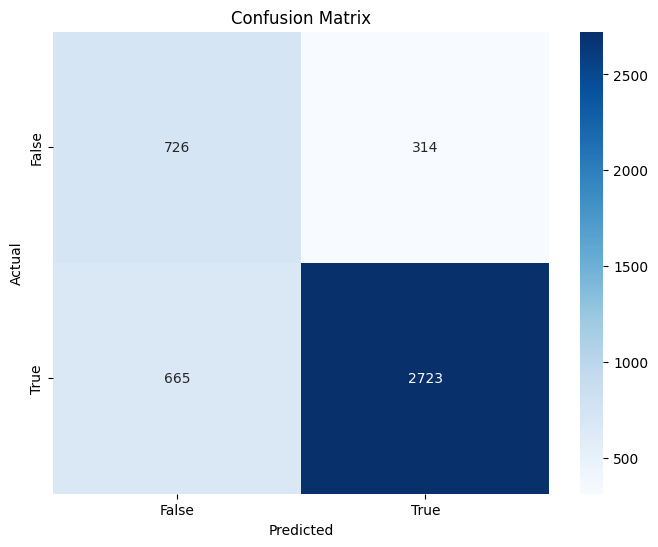

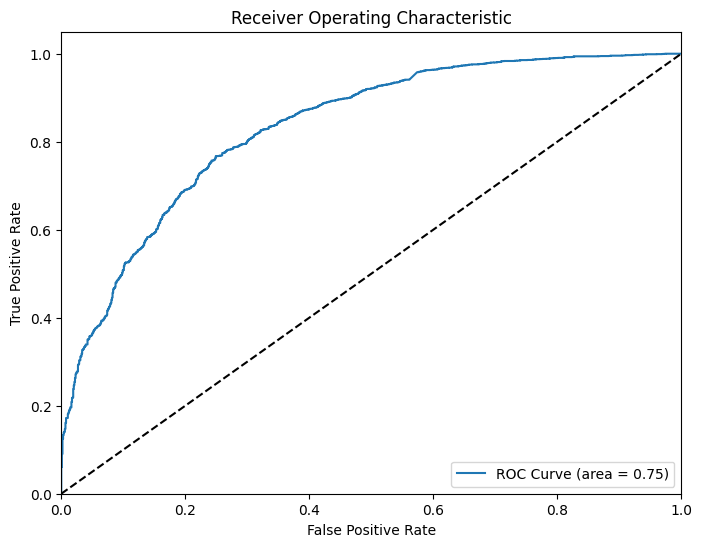


Logistic Regression with Hyperparameter Tuning (PolitiFact):
Best Parameters: {'C': 1, 'solver': 'liblinear'}
Best cross-validation score: 0.8394
Accuracy: 0.7962
Precision: 0.8919
Recall: 0.7615
F1-score: 0.8216
ROC AUC: 0.8067
Confusion Matrix:
[[69 12]
 [31 99]]


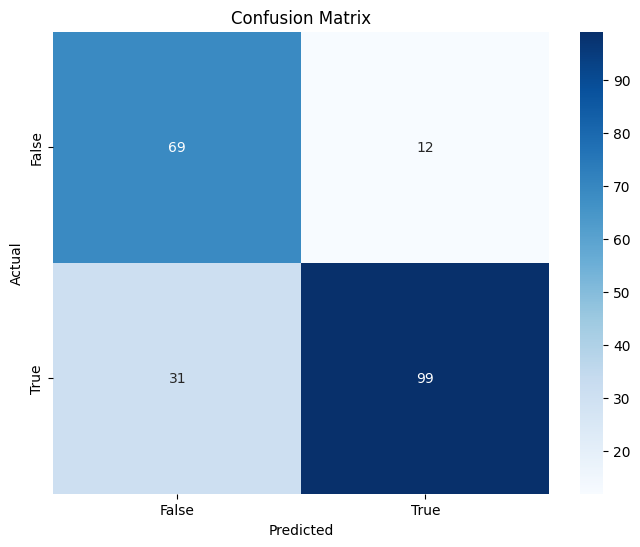

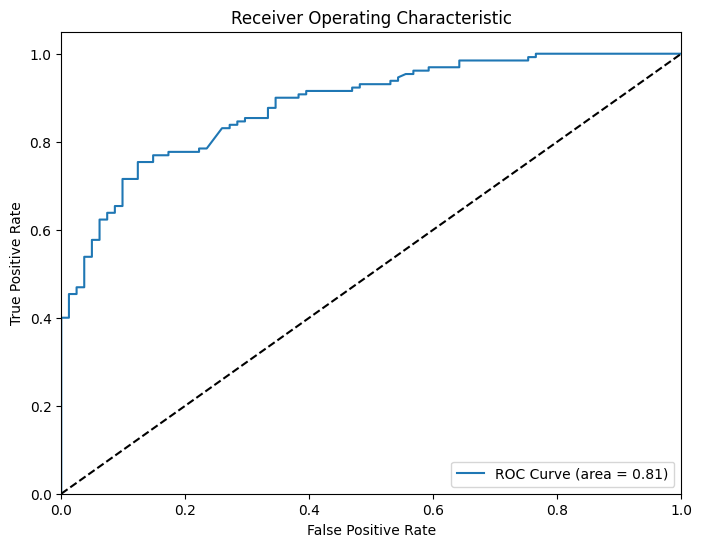


Support Vector Machine with Hyperparameter Tuning (GossipCop):
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best cross-validation score: 0.9207
Accuracy: 0.8399
Precision: 0.8741
Recall: 0.9238
F1-score: 0.8983
ROC AUC: 0.7451
Confusion Matrix:
[[ 589  451]
 [ 258 3130]]


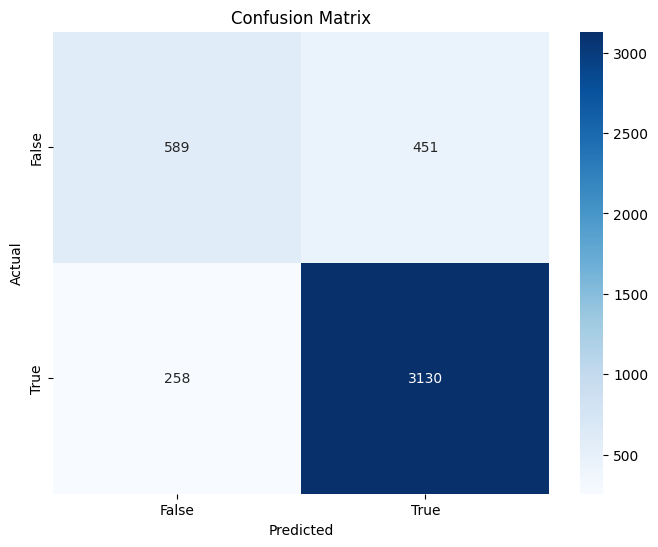

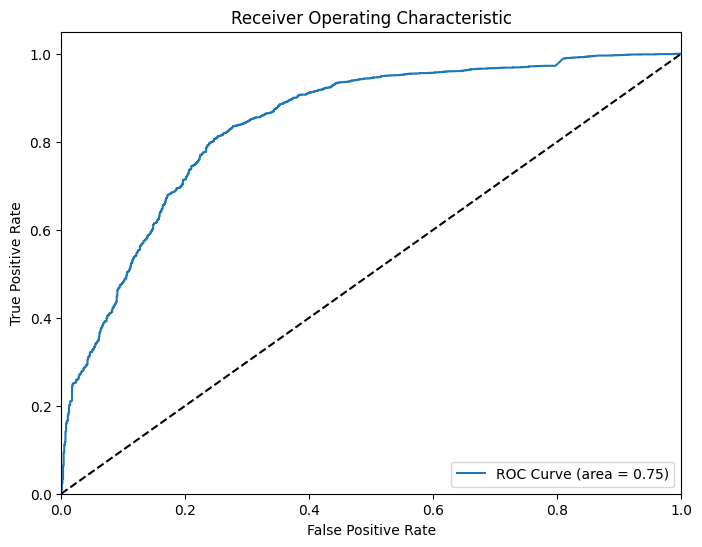


Support Vector Machine with Hyperparameter Tuning (PolitiFact):
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.8650
Accuracy: 0.7962
Precision: 0.8321
Recall: 0.8385
F1-score: 0.8352
ROC AUC: 0.7834
Confusion Matrix:
[[ 59  22]
 [ 21 109]]


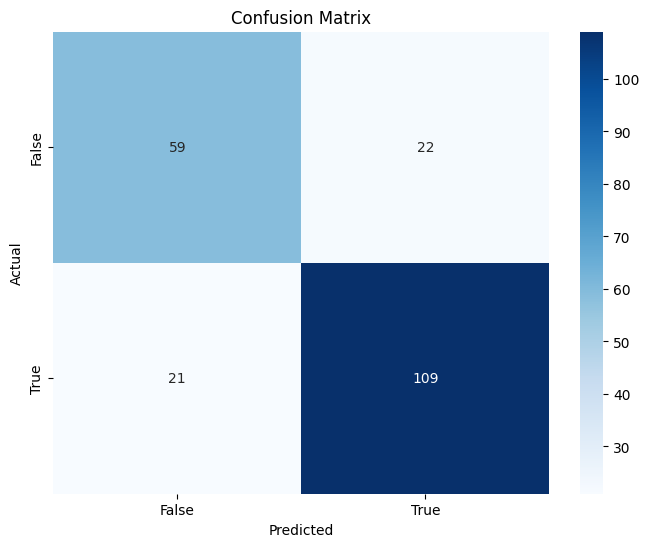

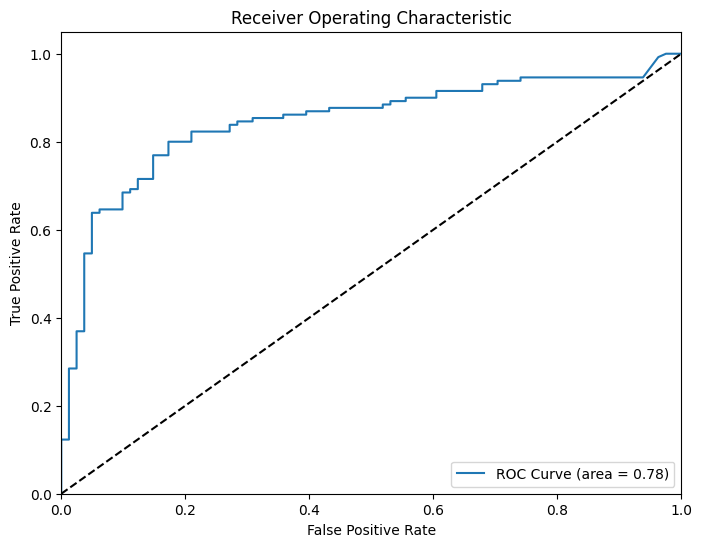


Naive Bayes with Hyperparameter Tuning (GossipCop):
Best Parameters: {'alpha': 0.1}
Best cross-validation score: 0.7837
Accuracy: 0.7807
Precision: 0.8990
Recall: 0.8037
F1-score: 0.8487
ROC AUC: 0.7547
Confusion Matrix:
[[ 734  306]
 [ 665 2723]]


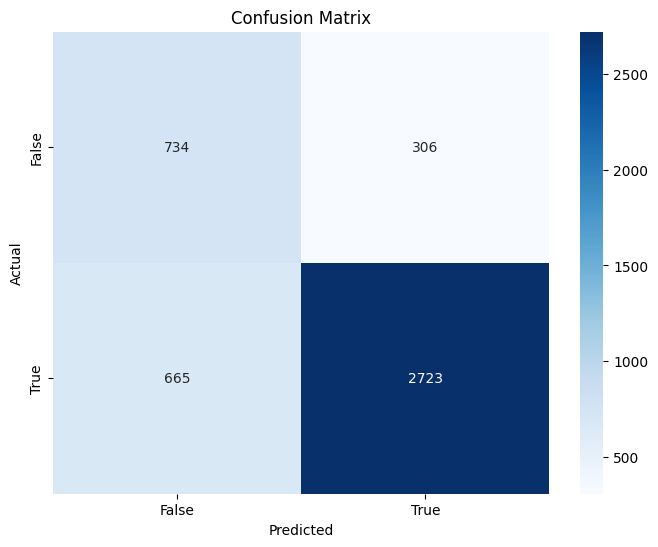

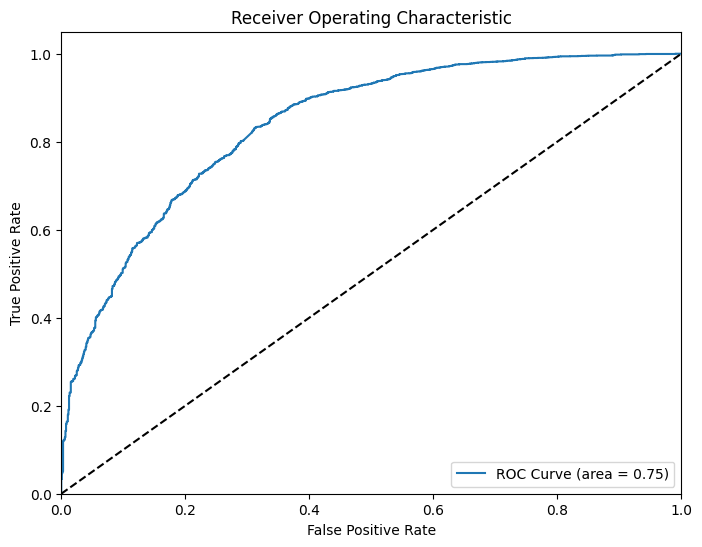


Naive Bayes with Hyperparameter Tuning (PolitiFact):
Best Parameters: {'alpha': 1}
Best cross-validation score: 0.8550
Accuracy: 0.7867
Precision: 0.8761
Recall: 0.7615
F1-score: 0.8148
ROC AUC: 0.7943
Confusion Matrix:
[[67 14]
 [31 99]]


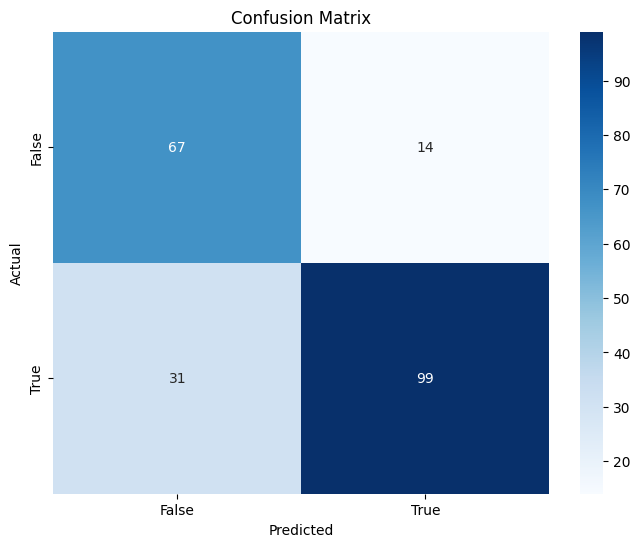

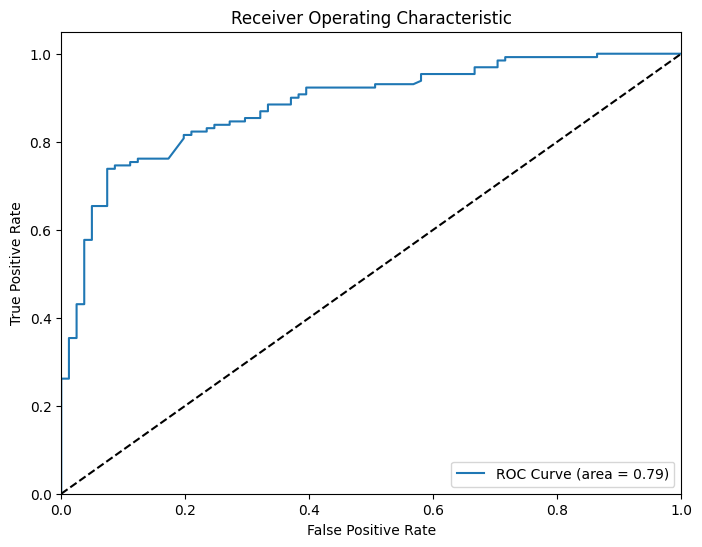

(MultinomialNB(alpha=1),
 array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))

In [12]:
# Logistic Regression with Hyperparameter Tuning
print("Logistic Regression with Hyperparameter Tuning (GossipCop):")
tune_and_evaluate(LogisticRegression(max_iter=1000, random_state=42), logistic_params,
                  X_train_gossipcop_resampled, X_test_gossipcop_tfidf, y_train_gossipcop_resampled, y_test_gossipcop)

print("\nLogistic Regression with Hyperparameter Tuning (PolitiFact):")
tune_and_evaluate(LogisticRegression(max_iter=1000, random_state=42), logistic_params,
                  X_train_politifact_resampled, X_test_politifact_tfidf, y_train_politifact_resampled, y_test_politifact)

# Support Vector Machine (SVM) with Hyperparameter Tuning
print("\nSupport Vector Machine with Hyperparameter Tuning (GossipCop):")
tune_and_evaluate(SVC(random_state=42), svm_params,
                  X_train_gossipcop_resampled, X_test_gossipcop_tfidf, y_train_gossipcop_resampled, y_test_gossipcop)

print("\nSupport Vector Machine with Hyperparameter Tuning (PolitiFact):")
tune_and_evaluate(SVC(random_state=42), svm_params,
                  X_train_politifact_resampled, X_test_politifact_tfidf, y_train_politifact_resampled, y_test_politifact)

# Naive Bayes with Hyperparameter Tuning
print("\nNaive Bayes with Hyperparameter Tuning (GossipCop):")
tune_and_evaluate(MultinomialNB(), nb_params,
                  X_train_gossipcop_resampled, X_test_gossipcop_tfidf, y_train_gossipcop_resampled, y_test_gossipcop)

print("\nNaive Bayes with Hyperparameter Tuning (PolitiFact):")
tune_and_evaluate(MultinomialNB(), nb_params,
                  X_train_politifact_resampled, X_test_politifact_tfidf, y_train_politifact_resampled, y_test_politifact)

Logistic Regression

GossipCop:

    Original:
        Accuracy: 0.7850
        F1-score: 0.8520
        ROC AUC: 0.7579
    Fine-Tuned:
        Accuracy: 0.7789 (slightly worse)
        F1-score: 0.8476 (slightly worse)
        ROC AUC: 0.7509 (worse)

PolitiFact:

    Both original and fine-tuned models have identical metrics.

Support Vector Machine

GossipCop:

    Original:
        Accuracy: 0.7764
        F1-score: 0.8449
        ROC AUC: 0.7543
    Fine-Tuned:
        Accuracy: 0.8399 (improved)
        F1-score: 0.8983 (improved)
        ROC AUC: 0.7451 (slightly worse)

PolitiFact:

    Original:
        Accuracy: 0.7820
        F1-score: 0.8099
        ROC AUC: 0.7905
    Fine-Tuned:
        Accuracy: 0.7962 (improved)
        F1-score: 0.8352 (improved)
        ROC AUC: 0.7834 (slightly worse)

Naive Bayes

GossipCop:

    Original:
        Accuracy: 0.7809
        F1-score: 0.8485
        ROC AUC: 0.7572
    Fine-Tuned:
        Accuracy: 0.7807 (about the same)
        F1-score: 0.8487 (about the same)
        ROC AUC: 0.7547 (slightly worse)

PolitiFact:

    Both original and fine-tuned models have identical metrics.

Hyperparameter tuning has led to some improvements, especially in the case of SVM on the GossipCop dataset. However, for Logistic Regression and Naive Bayes, the changes are minimal.

## Save the Best Model to Google Drive

In [13]:
# Selecting svm_model_gossipcop as the best model after hyperparameter tuning
best_model = SVC(C=10, kernel='rbf', random_state=42)
best_model.fit(X_train_gossipcop_resampled, y_train_gossipcop_resampled)

# Save the model to a file
model_filename = '/content/drive/My Drive/best_svm_model_gossipcop.pkl'
joblib.dump(best_model, model_filename)

# Save the TF-IDF vectorizer to a file
vectorizer_filename = '/content/drive/My Drive/tfidf_vectorizer_gossipcop.pkl'
joblib.dump(vectorizer, vectorizer_filename)

print("Model and vectorizer saved to Google Drive.")

Model and vectorizer saved to Google Drive.


## Conclusion

My models significantly outperform the baseline results across all metrics for both datasets (GossipCop and PolitiFact).
Balancing the datasets with SMOTE and tuning hyperparameters further improved the models' performance.

Based on the evaluation metrics (accuracy, precision, recall, F1-score, and ROC AUC) for each classifier, the Support Vector Machine (SVM) with hyperparameter tuning on the GossipCop dataset seems to perform the best overall.


## References

[5] BIAN, T., XIAO, X., XU, T., ZHAO, P., HUANG, W., RONG, Y., and HUANG, J. 2020. Rumor Detection on Social Media with Bi-Directional Graph Convolutional Networks. arXiv preprint arXiv:2001.06362. https://doi.org/10.48550/arXiv.2001.06362

[6] SHEN, Y., LIU, Q., GUO, N., YUAN, J., and YANG, Y. 2023. Fake News Detection on Social Networks: A Survey. Applied Sciences, 13, 11877. https://doi.org/10.3390/app132111877

[7] SHU, K., MAHUDESWARAN, D., WANG, S., LEE, D., and LIU, H. 2018. FakeNewsNet: A Data Repository with News Content, Social Context and Dynamic Information for Studying Fake News on Social Media. https://doi.org/10.48550/arXiv.1809.01286

[14] CHAWLA, N.V., BOWYER, K.W., HALL, L.O., and KEGELMEYER, W.P. 2002. SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16, 321-357. https://doi.org/10.48550/arXiv.1106.1813

[15] BROWNE, M.W. 2000. Cross-Validation Methods. Journal of Mathematical Psychology, 44, 108–132. https://doi.org/10.1006/jmps.1999.1279

[16] POWERS, D.M.W. 2011. Evaluation: From Precision, Recall and F-measure to ROC, Informedness, Markedness and Correlation. International Journal of Machine Learning Technology, 2(1), pp. 37-63. https://doi.org/10.48550/arXiv.2010.16061

[17] CHONG, K. and SHAH, N. 2022. Comparison of Naive Bayes and SVM Classification in Grid-Search Hyperparameter Tuned and Non-Hyperparameter Tuned Healthcare Stock Market Sentiment Analysis. International Journal of Advanced Computer Science and Applications, 13(12), pp. 90-94. DOI: 10.14569/IJACSA.2022.0131213


In [14]:
# Install LaTeX packages necessary for converting notebooks to PDF
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic texlive-latex-extra pandoc

# Convert the notebook to PDF
!jupyter nbconvert --to pdf "/content/drive/My Drive/Colab Notebooks/FakeNewsNetClassifier.ipynb"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,998 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 https://r2u.stat.il